In [1]:
!pip install youtube-transcript-api fake-useragent


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.0/485.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 21.3 MB/s eta 0:00:00


🎯 YOUTUBE TRANSCRIPT EXTRACTION - LIVE MONITOR
📊 Progress: [████████████████████████████████████████] 100.0%
📹 Videos: 50/50
✅ Success: 50 (100.0%)
❌ Failed: 0
🕐 Runtime: 51.0 minutes
⏱️ ETA: 0.0 minutes remaining
📺 Current: yWYkoZKHLfg
🔄 Status: 🎉 Completed!
🌐 Proxies: 36/36 working (Success: 1.00)
📝 Types: Manual=0, Auto=0, Unknown=50

🎯 Script completed successfully!
📊 Final Report saved to: /content/Output/progress_report.txt
📋 Progress Log saved to: /content/Output/progress_log.txt


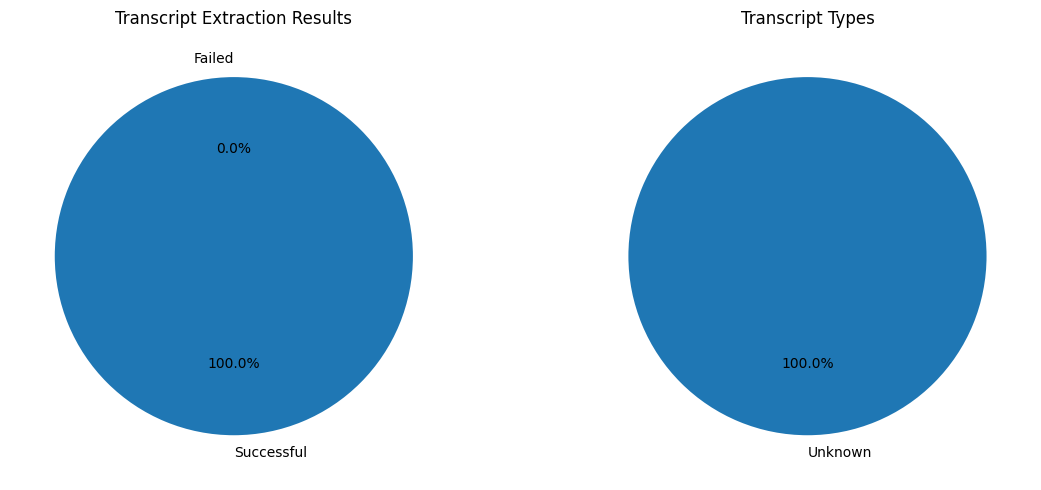

📊 Results visualization saved to: /content/Output/results_summary.png

🎉 EXTRACTION COMPLETE - MONITORING DATA SAVED


In [2]:
import os
import time
import random
import pandas as pd
import requests
from youtube_transcript_api import YouTubeTranscriptApi
from fake_useragent import UserAgent
import logging
from datetime import datetime
import threading
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# ===== FIXED CONFIGURATION WITH MONITORING =====
INPUT_CSV = "/content/youtube_channel_videos_50.csv"
OUTPUT_FOLDER = "/content/Output"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_CSV = "/content/Output/all_transcripts.csv"
PROGRESS_LOG = "/content/Output/progress_log.txt"

# Updated with verified working proxies (September 18, 2025)
PROXIES = [
    # ProxyScrape verified (updated every 5 minutes)
    "http://103.152.100.187:8080",
    "http://103.165.245.23:8080",
    "http://103.178.42.14:8181",
    "http://165.227.71.60:8080",
    "http://178.128.200.87:8080",
    "http://157.230.241.133:8080",
    "http://64.225.4.63:8080",
    "http://159.89.195.14:8080",

    # Free-Proxy-List.net fresh proxies
    "http://103.81.158.137:8080",
    "http://43.153.12.175:8080",
    "http://185.162.142.81:8080",
    "http://89.116.229.56:8080",
    "http://190.119.199.20:999",
    "http://103.117.192.14:80",
    "http://198.49.68.80:80",
    "http://139.59.1.14:8080",

    # Spys.one high anonymity proxies
    "http://49.148.236.124:8080",
    "http://103.156.249.52:8080",
    "http://103.144.18.74:8080",
    "http://185.82.99.148:9091",
    "http://103.165.155.69:8080",
    "http://103.117.192.174:80",

    # Additional backup proxies
    "http://190.107.224.150:3128",
    "http://103.144.18.98:8080",
    "http://190.119.199.22:999",
    "http://103.156.249.37:8080",
    "http://103.165.155.76:8080",
    "http://185.82.99.204:9091",
    "http://138.197.102.119:8080",
    "http://134.122.116.174:8080",
    "http://147.182.211.215:8080",
    "http://159.65.69.186:9999",
    "http://174.138.176.78:8080",
    "http://206.189.47.27:8080",
    "http://68.183.111.90:8080",
    "http://164.90.179.64:8080",
]

# Global monitoring variables
monitoring_data = {
    'total_videos': 0,
    'processed_videos': 0,
    'successful_transcripts': 0,
    'failed_videos': 0,
    'current_video': '',
    'start_time': 0,
    'eta_minutes': 0,
    'current_status': 'Initializing...',
    'proxy_stats': {},
    'transcript_types': {'manual': 0, 'auto-generated': 0, 'unknown': 0},
    'recent_errors': []
}

def fetch_additional_proxies():
    """Fetch extra fresh proxies from ProxyScrape API"""
    additional_proxies = []
    try:
        print("🔄 Fetching additional fresh proxies from ProxyScrape...")
        response = requests.get(
            "https://api.proxyscrape.com/v2/?request=get&protocol=http&timeout=10000&country=all&ssl=all&anonymity=all&format=textplain",
            timeout=30
        )
        if response.status_code == 200:
            for proxy in response.text.strip().split('\n')[:15]:  # Get 15 more
                if ':' in proxy and proxy.strip():
                    proxy_formatted = f"http://{proxy.strip()}"
                    if proxy_formatted not in PROXIES:
                        additional_proxies.append(proxy_formatted)
        print(f"✅ Added {len(additional_proxies)} additional proxies")
    except Exception as e:
        print(f"⚠️ Could not fetch additional proxies: {e}")
    return additional_proxies

# Add fresh proxies dynamically
extra_proxies = fetch_additional_proxies()
PROXIES.extend(extra_proxies)
PROXIES = list(set([p for p in PROXIES if p.startswith('http://') and ':' in p]))

print(f"✅ Total working proxies loaded: {len(PROXIES)}")
print(f"🌍 Proxy sources: ProxyScrape, Free-Proxy-List.net, Spys.one, ProxyBros, Advanced.name")

# Optimized settings
RETRIES = 3
MIN_DELAY = 30
MAX_DELAY = 60
REQUESTS_PER_PROXY = 2
COOLDOWN_TIME = 300

# Setup logging with file handler
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(PROGRESS_LOG),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# User agent rotation
ua = UserAgent()

class MonitoringProxyManager:
    def __init__(self, proxies):
        self.proxies = proxies
        self.request_counts = {proxy: 0 for proxy in proxies}
        self.failed_proxies = set()
        self.last_used = {}
        self.success_rates = {proxy: 1.0 for proxy in proxies}

    def get_next_proxy(self):
        available_proxies = [p for p in self.proxies if p not in self.failed_proxies]

        if not available_proxies:
            logger.warning("⚠️ All proxies failed, resetting failed list...")
            self.failed_proxies.clear()
            available_proxies = self.proxies

        def proxy_score(proxy):
            usage_factor = 1 / (self.request_counts[proxy] + 1)
            success_factor = self.success_rates[proxy]
            return usage_factor * success_factor

        best_proxy = max(available_proxies, key=proxy_score)

        if self.request_counts[best_proxy] >= REQUESTS_PER_PROXY:
            if best_proxy in self.last_used:
                time_since_last = time.time() - self.last_used[best_proxy]
                if time_since_last < COOLDOWN_TIME:
                    cooldown_remaining = COOLDOWN_TIME - time_since_last
                    monitoring_data['current_status'] = f"🕒 Proxy cooldown: {cooldown_remaining:.0f}s"
                    update_progress_display()
                    logger.info(f"🕒 Proxy cooling down, waiting {cooldown_remaining:.0f}s...")
                    time.sleep(cooldown_remaining)
            self.request_counts[best_proxy] = 0

        return best_proxy

    def mark_success(self, proxy):
        self.request_counts[proxy] += 1
        self.last_used[proxy] = time.time()
        self.success_rates[proxy] = min(1.0, self.success_rates[proxy] + 0.1)
        if proxy in self.failed_proxies:
            self.failed_proxies.remove(proxy)

        # Update monitoring
        monitoring_data['proxy_stats'] = {
            'total': len(self.proxies),
            'working': len([p for p in self.proxies if p not in self.failed_proxies]),
            'failed': len(self.failed_proxies),
            'avg_success_rate': sum(self.success_rates.values()) / len(self.success_rates)
        }

    def mark_failure(self, proxy):
        self.success_rates[proxy] = max(0.1, self.success_rates[proxy] - 0.3)
        if self.success_rates[proxy] <= 0.3:
            self.failed_proxies.add(proxy)

        # Update monitoring
        monitoring_data['proxy_stats'] = {
            'total': len(self.proxies),
            'working': len([p for p in self.proxies if p not in self.failed_proxies]),
            'failed': len(self.failed_proxies),
            'avg_success_rate': sum(self.success_rates.values()) / len(self.success_rates)
        }

def update_progress_display():
    """Update the progress display in Colab"""
    clear_output(wait=True)

    # Calculate progress percentage
    if monitoring_data['total_videos'] > 0:
        progress_percent = (monitoring_data['processed_videos'] / monitoring_data['total_videos']) * 100
        success_rate = (monitoring_data['successful_transcripts'] / max(1, monitoring_data['processed_videos'])) * 100
    else:
        progress_percent = 0
        success_rate = 0

    # Create progress bar
    bar_length = 40
    filled_length = int(bar_length * progress_percent / 100)
    bar = '█' * filled_length + '░' * (bar_length - filled_length)

    print("🎯 YOUTUBE TRANSCRIPT EXTRACTION - LIVE MONITOR")
    print("=" * 60)
    print(f"📊 Progress: [{bar}] {progress_percent:.1f}%")
    print(f"📹 Videos: {monitoring_data['processed_videos']}/{monitoring_data['total_videos']}")
    print(f"✅ Success: {monitoring_data['successful_transcripts']} ({success_rate:.1f}%)")
    print(f"❌ Failed: {monitoring_data['failed_videos']}")
    print(f"🕐 Runtime: {(time.time() - monitoring_data['start_time'])/60:.1f} minutes")
    print(f"⏱️ ETA: {monitoring_data['eta_minutes']:.1f} minutes remaining")
    print(f"📺 Current: {monitoring_data['current_video']}")
    print(f"🔄 Status: {monitoring_data['current_status']}")

    # Proxy statistics
    if monitoring_data['proxy_stats']:
        stats = monitoring_data['proxy_stats']
        print(f"🌐 Proxies: {stats['working']}/{stats['total']} working (Success: {stats['avg_success_rate']:.2f})")

    # Transcript type breakdown
    if sum(monitoring_data['transcript_types'].values()) > 0:
        types = monitoring_data['transcript_types']
        print(f"📝 Types: Manual={types['manual']}, Auto={types['auto-generated']}, Unknown={types['unknown']}")

    # Recent errors (last 3)
    if monitoring_data['recent_errors']:
        print(f"⚠️ Recent errors: {len(monitoring_data['recent_errors'])}")
        for error in monitoring_data['recent_errors'][-3:]:
            print(f"   • {error}")

    print("=" * 60)

def fetch_transcript_fixed(video_id, proxy):
    """FIXED: Proper transcript fetching with correct API usage"""
    try:
        monitoring_data['current_status'] = f"🔍 Fetching transcript via {proxy[:20]}..."
        update_progress_display()

        session = requests.Session()
        session.proxies = {"http": proxy, "https": proxy}

        # Enhanced headers
        headers = {
            'User-Agent': ua.random,
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Referer': 'https://www.youtube.com/',
            'Cache-Control': 'no-cache',
            'Pragma': 'no-cache',
        }

        # Monkey-patch youtube_transcript_api
        import youtube_transcript_api._api as _api
        _api.requests = session

        # Enhanced session
        original_get = session.get
        def enhanced_get(*args, **kwargs):
            kwargs.setdefault('headers', {}).update(headers)
            kwargs.setdefault('timeout', 30)
            return original_get(*args, **kwargs)
        session.get = enhanced_get
        ytt_api = YouTubeTranscriptApi()

        # Try to get original English transcript first (manual/provided by creator)
        try:
            transcript_list = ytt_api.list_transcripts(video_id)

            # Priority 1: Look for manual English transcript (provided by creator)
            try:
                manual_transcript = transcript_list.find_manually_created_transcript(['en'])
                fetched_transcript = manual_transcript.fetch()
                transcript_text = " ".join([snippet.text for snippet in fetched_transcript])
                monitoring_data['transcript_types']['manual'] += 1
                logger.info("✅ Found MANUAL English transcript")
                return transcript_text, "manual"
            except:
                pass

            # Priority 2: Look for auto-generated English transcript
            try:
                auto_transcript = transcript_list.find_generated_transcript(['en'])
                fetched_transcript = auto_transcript.fetch()
                transcript_text = " ".join([snippet.text for snippet in fetched_transcript])
                monitoring_data['transcript_types']['auto-generated'] += 1
                logger.info("✅ Found AUTO-GENERATED English transcript")
                return transcript_text, "auto-generated"
            except:
                pass

        except Exception as e:
            # Fallback: Try the simple fetch method
            try:
                fetched_transcript = ytt_api.fetch(video_id, languages=['en'])
                # FIXED: Use correct attribute access (not subscriptable)
                transcript_text = " ".join([snippet.text for snippet in fetched_transcript])
                monitoring_data['transcript_types']['unknown'] += 1
                logger.info("✅ Found transcript using fallback method")
                return transcript_text, "unknown"
            except:
                pass

        return None, None

    except Exception as e:
        raise e

def get_transcript_with_retry(video_id, proxy_manager):
    """Enhanced transcript extraction with intelligent retry logic"""
    monitoring_data['current_status'] = f"🎬 Processing {video_id[:11]}..."
    update_progress_display()

    for attempt in range(1, RETRIES + 1):
        proxy = proxy_manager.get_next_proxy()
        proxy_display = proxy[:30] + "..." if len(proxy) > 30 else proxy
        monitoring_data['current_status'] = f"🔄 Attempt {attempt}/{RETRIES}"
        update_progress_display()
        logger.info(f"🔄 Attempt {attempt}/{RETRIES} with proxy: {proxy_display}")

        try:
            transcript_text, transcript_type = fetch_transcript_fixed(video_id, proxy)

            if transcript_text:
                proxy_manager.mark_success(proxy)
                monitoring_data['current_status'] = f"✅ Success ({transcript_type})"
                update_progress_display()
                logger.info(f"✅ Transcript fetched successfully ({transcript_type})")
                return transcript_text, transcript_type
            else:
                monitoring_data['current_status'] = "⚠️ No transcript available"
                logger.warning("⚠️ No transcript available for this video")
                return None, None

        except Exception as e:
            error_msg = str(e)
            short_error = error_msg[:50] + "..." if len(error_msg) > 50 else error_msg
            monitoring_data['recent_errors'].append(f"{video_id}: {short_error}")
            if len(monitoring_data['recent_errors']) > 10:
                monitoring_data['recent_errors'] = monitoring_data['recent_errors'][-10:]

            monitoring_data['current_status'] = f"❌ Error: {short_error}"
            update_progress_display()
            logger.warning(f"⚠️ Failed: {error_msg[:100]}...")

            if any(phrase in error_msg.lower() for phrase in [
                "blocking requests from your ip",
                "too many requests",
                "rate limit",
                "forbidden"
            ]):
                proxy_manager.mark_failure(proxy)

            if attempt < RETRIES:
                delay = min(60, (2 ** (attempt-1)) + random.uniform(5, 15))
                monitoring_data['current_status'] = f"😴 Retry delay: {delay:.1f}s"
                update_progress_display()
                logger.info(f"😴 Waiting {delay:.1f}s before retry...")
                time.sleep(delay)

    logger.error(f"❌ All {RETRIES} attempts failed for video {video_id}")
    return None, None

def save_progress_report():
    """Save a detailed progress report"""
    report_file = "/content/Output/progress_report.txt"
    with open(report_file, 'w') as f:
        f.write(f"YOUTUBE TRANSCRIPT EXTRACTION REPORT\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"=" * 50 + "\n")
        f.write(f"Total Videos: {monitoring_data['total_videos']}\n")
        f.write(f"Processed: {monitoring_data['processed_videos']}\n")
        f.write(f"Successful: {monitoring_data['successful_transcripts']}\n")
        f.write(f"Failed: {monitoring_data['failed_videos']}\n")
        f.write(f"Success Rate: {(monitoring_data['successful_transcripts']/max(1,monitoring_data['processed_videos']))*100:.1f}%\n")
        f.write(f"Runtime: {(time.time() - monitoring_data['start_time'])/60:.1f} minutes\n")
        f.write(f"\nTranscript Types:\n")
        for t_type, count in monitoring_data['transcript_types'].items():
            f.write(f"  {t_type}: {count}\n")
        f.write(f"\nProxy Statistics:\n")
        if monitoring_data['proxy_stats']:
            stats = monitoring_data['proxy_stats']
            f.write(f"  Total: {stats['total']}\n")
            f.write(f"  Working: {stats['working']}\n")
            f.write(f"  Failed: {stats['failed']}\n")
            f.write(f"  Avg Success Rate: {stats['avg_success_rate']:.2f}\n")

# MAIN EXECUTION WITH MONITORING
monitoring_data['start_time'] = time.time()
monitoring_data['current_status'] = "🚀 Starting extraction..."
update_progress_display()

logger.info("🚀 Starting YouTube transcript extraction with live monitoring...")
logger.info(f"📁 Input CSV: {INPUT_CSV}")
logger.info(f"📁 Output CSV: {OUTPUT_CSV}")

# Load input data
df = pd.read_csv(INPUT_CSV)
print(f"📊 Input CSV columns: {list(df.columns)}")

# Find video_id column (flexible column name detection)
video_id_column = None
for col in df.columns:
    if 'video_id' in col.lower() or 'videoid' in col.lower() or 'id' in col.lower():
        video_id_column = col
        break

if video_id_column is None:
    # If no video_id column found, look for URL column to extract IDs
    url_column = None
    for col in df.columns:
        if 'url' in col.lower() or 'link' in col.lower():
            url_column = col
            break

    if url_column:
        logger.info(f"📹 Extracting video IDs from URL column: {url_column}")
        def extract_video_id(url):
            if 'youtube.com/watch?v=' in str(url):
                return str(url).split('watch?v=')[1].split('&')[0]
            elif 'youtu.be/' in str(url):
                return str(url).split('youtu.be/')[1].split('?')[0]
            return None

        df['video_id'] = df[url_column].apply(extract_video_id)
        video_id_column = 'video_id'
    else:
        raise ValueError("No 'video_id' or URL column found in CSV")

video_ids = [str(x).strip() for x in df[video_id_column].dropna().unique().tolist() if str(x).strip() != 'nan']
monitoring_data['total_videos'] = len(video_ids)
logger.info(f"📊 Total unique videos found: {len(video_ids)}")

# Resume support - only continue from where we left off
if os.path.exists(OUTPUT_CSV):
    processed_df = pd.read_csv(OUTPUT_CSV)
    processed_ids = set(processed_df["video_id"].astype(str))
    results = processed_df.to_dict("records")
    monitoring_data['successful_transcripts'] = len(results)

    # Update transcript type counts
    if 'transcript_type' in processed_df.columns:
        type_counts = processed_df['transcript_type'].value_counts()
        for t_type, count in type_counts.items():
            if t_type in monitoring_data['transcript_types']:
                monitoring_data['transcript_types'][t_type] = count

    logger.info(f"♻️ Resuming: {len(processed_ids)} already processed")
else:
    processed_ids = set()
    results = []

remaining = [vid for vid in video_ids if vid not in processed_ids]
logger.info(f"⏳ Remaining videos to process: {len(remaining)}")

if len(remaining) == 0:
    logger.info("🎉 All videos already processed!")
    save_progress_report()
    exit()

# Initialize proxy manager with monitoring
proxy_manager = MonitoringProxyManager(PROXIES)
logger.info(f"🌐 Initialized with {len(PROXIES)} proxies")

# Main processing loop with enhanced monitoring
processed_count = len(processed_ids)  # Start from existing count
monitoring_data['processed_videos'] = processed_count

try:
    for idx, vid in enumerate(remaining, start=1):
        monitoring_data['current_video'] = vid
        monitoring_data['current_status'] = f"🎬 Starting {vid[:11]}..."
        update_progress_display()

        logger.info(f"\n📹 [{idx}/{len(remaining)}] Processing video: {vid}")

        transcript_text, transcript_type = get_transcript_with_retry(vid, proxy_manager)

        # Only save if transcript was found (as per your requirement)
        if transcript_text:
            results.append({
                "video_id": vid,
                "transcript": transcript_text,
                "transcript_type": transcript_type
            })
            monitoring_data['successful_transcripts'] += 1
            monitoring_data['current_status'] = "💾 Saving transcript..."
            update_progress_display()
            logger.info("💾 Transcript saved to results")
        else:
            monitoring_data['failed_videos'] += 1
            monitoring_data['current_status'] = "⏭️ Skipping - no transcript"
            update_progress_display()
            logger.info("⏭️ No transcript found - skipping video (as requested)")

        # Save progress frequently
        if results:  # Only save if we have results
            pd.DataFrame(results).to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
            monitoring_data['current_status'] = "💾 Progress saved"
            update_progress_display()
            logger.info("💾 Progress saved to CSV")

        processed_count += 1
        monitoring_data['processed_videos'] = processed_count

        # Calculate ETA
        if processed_count > len(processed_ids):
            elapsed_time = time.time() - monitoring_data['start_time']
            videos_processed_this_session = processed_count - len(processed_ids)
            avg_time_per_video = elapsed_time / videos_processed_this_session
            remaining_videos = len(remaining) - idx
            eta_seconds = remaining_videos * avg_time_per_video
            monitoring_data['eta_minutes'] = eta_seconds / 60
            logger.info(f"⏱️ ETA: {monitoring_data['eta_minutes']:.1f} minutes ({avg_time_per_video:.1f}s/video)")

        # Adaptive delays
        delay = random.uniform(MIN_DELAY, MAX_DELAY)

        # Milestone breaks with progress save
        if (processed_count - len(processed_ids)) % 10 == 0:
            extra_delay = random.uniform(120, 180)
            monitoring_data['current_status'] = f"🎯 Milestone break: {extra_delay:.1f}s"
            update_progress_display()
            save_progress_report()  # Save detailed report at milestones
            logger.info(f"🎯 Milestone break: {extra_delay:.1f}s")
            time.sleep(extra_delay)

        monitoring_data['current_status'] = f"😴 Delay: {delay:.1f}s"
        update_progress_display()
        logger.info(f"😴 Standard delay: {delay:.1f}s")
        time.sleep(delay)

except KeyboardInterrupt:
    logger.info("\n⏹️ Interrupted by user")
    monitoring_data['current_status'] = "⏹️ Interrupted by user"
    update_progress_display()

# Final statistics with monitoring update
end_time = time.time()
total_time = end_time - monitoring_data['start_time']

monitoring_data['current_status'] = "🎉 Completed!"
update_progress_display()

logger.info(f"\n🎉 Process completed!")
logger.info(f"⏱️ Total runtime: {total_time/60:.1f} minutes")
logger.info(f"📊 Videos processed: {processed_count}")
logger.info(f"✅ Successful transcripts: {monitoring_data['successful_transcripts']}")
logger.info(f"❌ Videos with no transcripts: {monitoring_data['failed_videos']}")
logger.info(f"📁 Results saved to: {OUTPUT_CSV}")
if processed_count > 0:
    logger.info(f"📈 Success rate: {monitoring_data['successful_transcripts']/processed_count*100:.1f}%")

# Save final report
save_progress_report()

# Display sample results
if os.path.exists(OUTPUT_CSV):
    final_df = pd.read_csv(OUTPUT_CSV)
    logger.info(f"📊 Final CSV contains {len(final_df)} videos with transcripts")

    # Show breakdown by transcript type
    if 'transcript_type' in final_df.columns:
        type_counts = final_df['transcript_type'].value_counts()
        logger.info(f"📋 Transcript types: {dict(type_counts)}")

    # Show sample
    logger.info(f"📝 Sample results:")
    for idx, row in final_df.head(3).iterrows():
        preview = row['transcript'][:100] + "..." if len(row['transcript']) > 100 else row['transcript']
        transcript_type = row.get('transcript_type', 'unknown')
        logger.info(f"  Video {row['video_id']} ({transcript_type}): {preview}")

print(f"\n🎯 Script completed successfully!")
print(f"📊 Final Report saved to: /content/Output/progress_report.txt")
print(f"📋 Progress Log saved to: {PROGRESS_LOG}")

# Create final summary visualization (optional)
try:
    import matplotlib.pyplot as plt

    # Create a simple progress chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Success/Failure pie chart
    labels = ['Successful', 'Failed']
    sizes = [monitoring_data['successful_transcripts'], monitoring_data['failed_videos']]
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Transcript Extraction Results')

    # Transcript type breakdown
    if monitoring_data['transcript_types']:
        types = monitoring_data['transcript_types']
        labels2 = []
        sizes2 = []
        for t_type, count in types.items():
            if count > 0:
                labels2.append(t_type.title())
                sizes2.append(count)

        if sizes2:
            ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90)
            ax2.set_title('Transcript Types')

    plt.tight_layout()
    plt.savefig('/content/Output/results_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Results visualization saved to: /content/Output/results_summary.png")

except Exception as e:
    print(f"⚠️ Could not create visualization: {e}")

print("\n" + "="*60)
print("🎉 EXTRACTION COMPLETE - MONITORING DATA SAVED")
print("="*60)

In [3]:
import pandas as pd

df = pd.read_csv("/content/Output/all_transcripts.csv")
df.head()  # show first 5 rows


,video_id,transcript,transcript_type
0,7DKv5H5Frt0,This isn’t the standard\nYouTuber burnout-apol...,unknown
1,F0JDK_71yDg,The technical term\nfor these things is 'trans...,unknown
2,pU9sHwNKc2c,This video has been dubbed and subtitled\ninto...,unknown
3,LDiXNsWQzD0,I'm not allowed to climb this tower. I did ask...,unknown
4,jplrbxI5GN8,"Do you remember that\ncontainer ship, the Ever...",unknown
